# Обучение модели

In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path

NOTEBOOK_ID = '3'
RANDOM_SEED = 0  # для воспроизводимости результатов
ROOT_PATH = Path('..')  # путь к корню проекта

MODEL_NAME = 'gama_ASH_600s_2'

# отключаем печать некоторых предупреждений
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import importlib.util
import sys

import dill
import numpy as np
import pandas as pd

import uai.models

In [3]:
# Загружаем обучающие и тестовые данные, уже очищенные от неверных значений

X_train = pd.read_csv(ROOT_PATH / 'data/processed/train_X__pipe_main_fittedon_train_1.csv')
y_train = pd.read_csv(ROOT_PATH / 'data/processed/train_y_1.csv')

print('Обучающая выборка:', X_train.shape)

X_test = pd.read_csv(ROOT_PATH / 'data/processed/test_X__pipe_main_fittedon_train_1.csv')
y_test = pd.read_csv(ROOT_PATH / 'data/processed/test_y_1.csv')

print('Тестовая выборка: ', X_test.shape)

Обучающая выборка: (1164, 67)
Тестовая выборка:  (292, 67)


In [4]:
# Загружаем еще не обученную модель, существую пока в виде кода на Питоне

spec = importlib.util.spec_from_file_location(
    MODEL_NAME,
    ROOT_PATH / f'models/predictors/{MODEL_NAME}.py'
)

# извлекаем объект модели из модуля
module = importlib.util.module_from_spec(spec)
sys.modules[MODEL_NAME] = module
spec.loader.exec_module(module)
model = module.pipeline
model

Pipeline(steps=[('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
                ('oh-enc', OneHotEncoder(cols=[])),
                ('target_enc', TargetEncoder(cols=[])),
                ('imputation', SimpleImputer(strategy='median')),
                ('1',
                 FeatureAgglomeration(affinity='euclidean', linkage='average')),
                ('0', KNeighborsRegressor(n_neighbors=37, weights='distance'))])

In [5]:
# Обучаем модель и сохраняем ее в файл

model.fit(X_train, y_train)

fname = ROOT_PATH / f'models/predictors/{MODEL_NAME}_fittedon_train_{NOTEBOOK_ID}.dill'
with open(fname, 'wb') as f:
    dill.dump(model, f, recurse=True)

In [6]:
# На всякий случай проверим, что модель удается восстановить из файла

# fname = '../models/predictors/gama_ASH_AS_2_fittedon_train_3.dill'
with open(fname, 'rb') as f:
    _ = dill.load(f)

Лучшие значения из экспериментов Андрея Совцова (просто для сравнения):
```
Средняя абсолютная ошибка (MAE):                         0.36
Среднеквадратичная ошибка (MSE):                         0.66
Коэффициент детерминации (R^2):                          0.73
Средняя абсолютная процентная ошибка (MAPE):            13.32%
Доля предсказаний с отклонением не более 0,5 мг:        72.60%
```

-- Метрики на тестовой выборке:
Средняя абсолютная ошибка (MAE):                         0.38
Среднеквадратичная ошибка (MSE):                         0.66
Коэффициент детерминации (R^2):                          0.73
Средняя абсолютная процентная ошибка (MAPE):            13.52%
Доля предсказаний с отклонением не более 0,5 мг:        73.63%


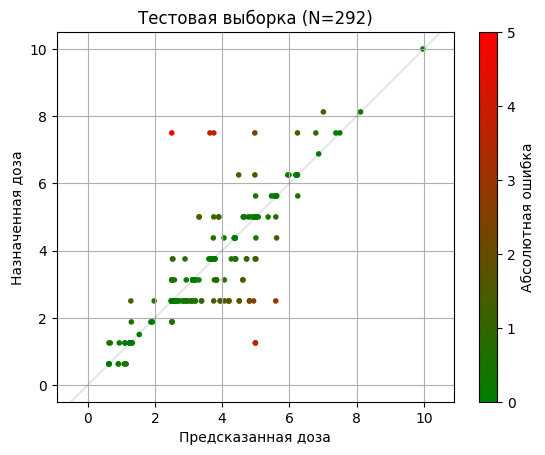

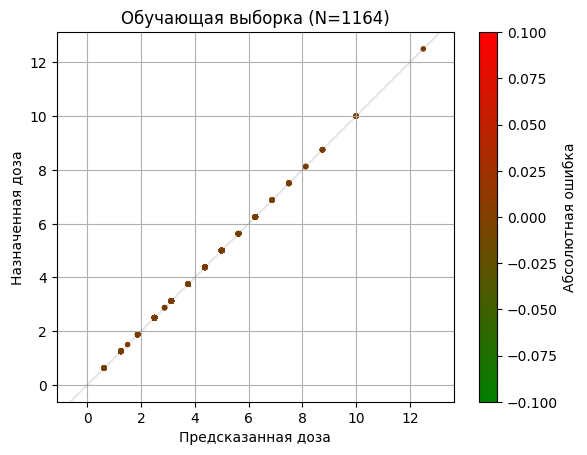

In [7]:
# Проверяем, как модель научилась предсказывать

predictions = model.predict(X_test)
rpredictions = np.round(predictions, 3)  # округление до точности исходных данных

metrics = uai.models.calculate_metrics(rpredictions, y_test)
print('-- Метрики на тестовой выборке:')
uai.models.print_metrics(metrics)

uai.models.plot_predictions(rpredictions, y_test.values, title='Тестовая выборка')

y_pred = model.predict(X_train)
uai.models.plot_predictions(y_pred, y_train.values, title='Обучающая выборка')

In [8]:
# Если ничего не напечаталось - то не дошли сюда, и где-то в ноутбуке ошибка
import datetime as dt
print('Ноутбук завершен:', dt.datetime.now())

Ноутбук завершен: 2023-11-22 16:41:26.430621
